In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

var = 'PRMSL'


In [3]:
# read data
filedir = '/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/data'

def prepare_df(var, validation=False):
    val_string = 'validation' if validation else ''
    df = pd.read_csv(f'{filedir}/{var}_obs{val_string}_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] <= '1821-12-31']
    df = df[df['Date'] >= '1806-01-01']
    df.index -= df.index[0] # reset indices
    return df

df_p = prepare_df('PRMSL')
df_ta = prepare_df('TMP2m')
df_ta = df_ta.drop(columns = df_ta.columns[0]) # weird 1st col
df_ta_validation = prepare_df('TMP2m', validation=True)
df_p_validation = prepare_df('PRMSL', validation=True)

df_ta.to_csv(f'{filedir}/TMP2m_obs_data_1806-1821.csv')
df_p.to_csv(f'{filedir}/PRMSL_obs_data_1808-1821.csv')

In [4]:
# modify names for temperature:
df_ta = df_ta.rename(columns={
    'AG01_Aarau_Zschogge': 'Aarau',
    'BE01_Bern_Fueter': 'Bern',
    'BE01_Bern_Studer': 'Bern2',
    'GR04_Marschlins': 'Schloss Marschlins',
    'JU01_Delemont': 'Delemont',
    'SH01_Schaffhausen': 'Schaffhausen',
    'VD01_Vevey': 'Vevey',
    'DigiHom_Geneva': 'Geneva',
    'KNMI-42_Zwanenburg': 'Zwanenburg',
    'KNMI-44_Haarlem': 'Haarlem',
    'KNMI-45_Delfft2': 'Delfft',
    'Europe_Rovereto_1': 'Rovereto',
    'GCOS_Zurich_Feer': 'Zurich',
    'IMPROVE_Cadiz': 'Cadiz',
    'IMPROVE_Stockholm': 'Stockholm',
    'IMPROVE_StPetersburg': 'St. Petersburg',
    'IMPROVE_Uppsala': 'Uppsala',
    'CRU_Paris': 'Paris',
    'Dom_Valencia': 'Valencia',
    'IMPROVE_Milan': 'Milan',
    'HAD_CET': 'CET',
    'Brug_Zitenice': 'Zitenice'
})

df_ta_validation = df_ta_validation.rename(columns={
    '5905_WIEN': 'Wien',
    'BAS_ta': 'Basel',
    'BOL_ta': 'Bologna',
    "Gdansk 'Excel sheet by Rajmund Przybylak": 'Gdansk'
})

df_p_validation = df_p_validation.rename(columns={
    'BAS_p': 'Basel',
    "Gdansk 'Excel sheet by Rajmund Przybylak": 'Gdansk'
})


In [5]:
# Function to extract continuous non-NaN segments
def get_segments(df, date_col="Date"):
    segments = []
    for station in df.columns[1:]:  # Skip the Date column
        data = df[[date_col, station]].dropna().reset_index(drop=True)
        if not data.empty:
            # Identify breaks in the sequence
            data['gap'] = data[date_col].diff().dt.days.ne(1).cumsum()
            for _, group in data.groupby('gap'):
                segments.append((station, group[date_col].iloc[0], group[date_col].iloc[-1]))
    return segments

# Get the actual non-NaN segments
segments_ta = get_segments(df_ta)
segments_p  = get_segments(df_p)
segments_ta_valid = get_segments(df_ta_validation)
segments_p_valid = get_segments(df_p_validation)

# unique station names
stations_ta = set([s[0] for s in segments_ta])
stations_p  = set([s[0] for s in segments_p])
stations_ta_valid = set([s[0] for s in segments_ta_valid])
stations_p_valid = set([s[0] for s in segments_p_valid])

# stations_all = list(stations_ta) + list(stations_p - stations_ta)
# stations_all.sort(key = lambda x: min(
#     [s[1] for s in segments_ta + segments_p if s[0]==x]))

stations_all = sorted(set(stations_ta | stations_p | stations_ta_valid | stations_p_valid),
                      reverse=True)


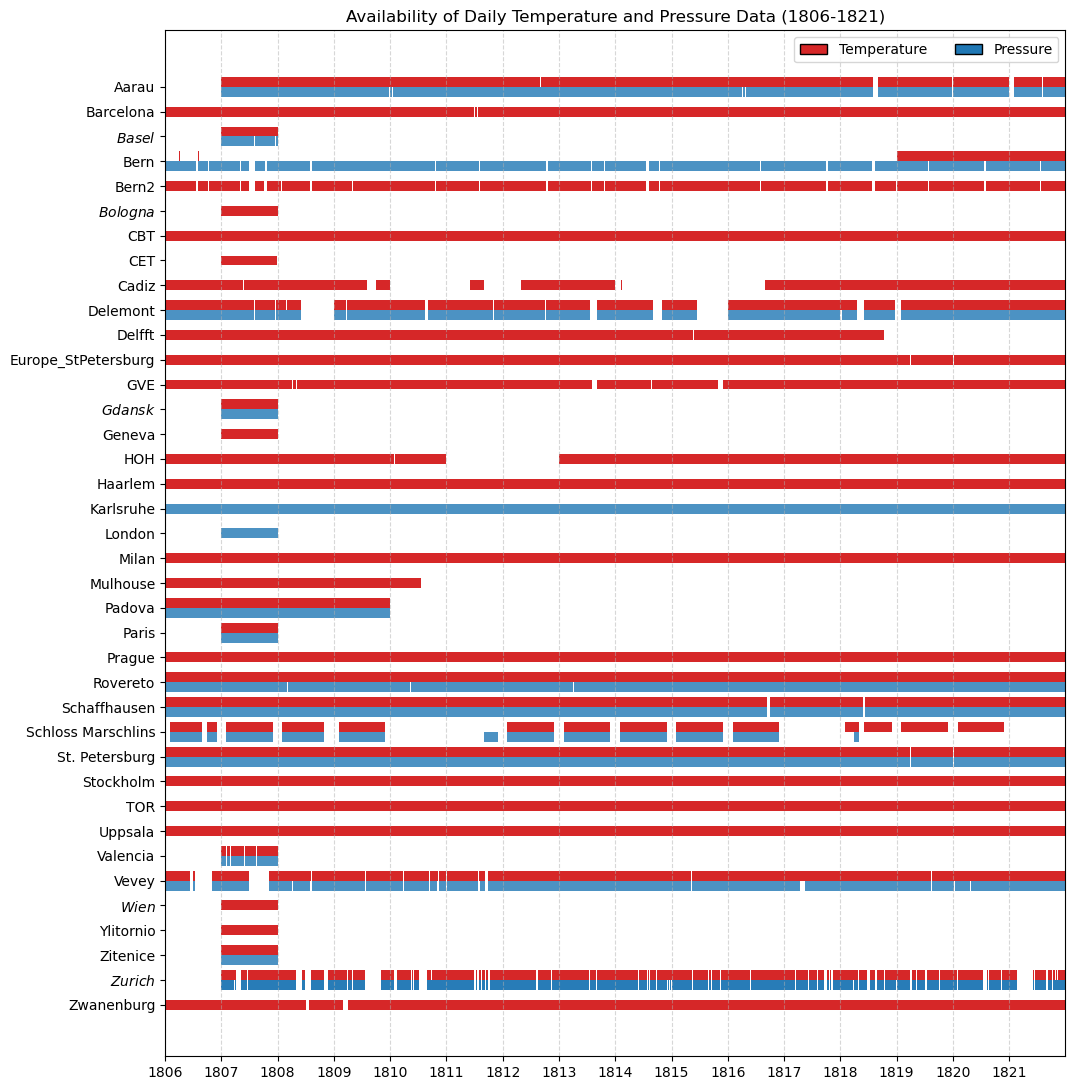

In [12]:
# Plot temperature and pressure data availability
offset = .4
station_positions = {station: i for i, station in enumerate(stations_all)}

fig, ax = plt.subplots(figsize=(12, len(stations_all) * 0.3))
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)  # More space on the left, less on the right, top, and bottom

ax.set_xlim(pd.Timestamp("1806-01-01"), pd.Timestamp("1821-12-31"))

for station, start, end in segments_p + segments_p_valid:
    # Shift down if both exist
    position = station_positions[station] if station not in (stations_ta | stations_ta_valid) else station_positions[station] - offset / 2
    ax.barh(position, width=(end - start).days, left=start,
            color='tab:blue', height=.4, align='center', alpha=0.8)

for station, start, end in segments_ta + segments_ta_valid:
    # Shift temperature bars up if pressure exists
    position = station_positions[station] if station not in (stations_p | stations_p_valid) else station_positions[station] + offset / 2
    ax.barh(position, width=(end - start).days, left=start, color='tab:red', height=0.4)


from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='tab:red', edgecolor='black', label='Temperature'),
    Patch(facecolor='tab:blue', edgecolor='black', label='Pressure')
]
ax.legend(handles=legend_elements, loc='upper right', ncol=2)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# italics for validation stations
yticks = [station_positions[st] for st in stations_all]
yticklabels = [f"$\\it{{{st}}}$" if st in (stations_ta_valid | stations_p_valid) else st for st in stations_all]

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_title("Availability of Daily Temperature and Pressure Data (1806-1821)")
ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/output/data_availability_plot.png')
plt.show()



In [21]:
sorted_names = pd.DataFrame(data={'names': sorted(stations_all)})
sorted_names

,names
0,Aarau
1,Barcelona
2,Basel
3,Bern
4,Bern2
5,Bologna
6,Brug_Zitenice
7,CBT
8,CET
9,Cadiz
